In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split

import re
import os
import math
import time
from tqdm.notebook import tqdm

In [2]:
class CFG:
    path = '../input/project-gutenberg/books/'
    max_len = 70
    max_len_auto = 50
    min_len = 5
    num_examples = None
    threshold = 0.9
    epochs = 10
    epochs_auto = 5

### Load book given its path

In [4]:
def load_book(path):
    with open(path) as f:
        book = f.read()
    return book

Loding books and book_names

In [5]:
book_names = [f for f in os.listdir(CFG.path)]
books = [load_book(CFG.path + book_name) for book_name in book_names]
len(books)

20

### Basic EDA

In [6]:
for i in range(len(books)):
    print(f"{len(books[i].split())} number of words in {book_names[i]}")

33464 number of words in Through_the_Looking_Glass_by_Lewis_Carroll.rtf
361612 number of words in Anna_Karenina_by_Leo_Tolstoy.rtf
96185 number of words in The_Adventures_of_Tom_Sawyer_by_Mark_Twain.rtf
194282 number of words in The_Romance_of_Lust_by_Anonymous.rtf
53211 number of words in The_Prince_by_Nicolo_Machiavelli.rtf
30423 number of words in Alices_Adventures_in_Wonderland_by_Lewis_Carroll.rtf
163109 number of words in Emma_by_Jane_Austen.rtf
110213 number of words in The_Adventures_of_Sherlock_Holmes_by_Arthur_Conan_Doyle.rtf
480495 number of words in The_Count_of_Monte_Cristo_by_Alexandre_Dumas.rtf
113452 number of words in David_Copperfield_by_Charles_Dickens.rtf
25395 number of words in Metamorphosis_by_Franz_Kafka.rtf
126999 number of words in Pride_and_Prejudice_by_Jane_Austen.rtf
83657 number of words in The_Picture_of_Dorian_Gray_by_Oscar_Wilde.rtf
166996 number of words in Dracula_by_Bram_Stoker.rtf
165188 number of words in Oliver_Twist_by_Charles_Dickens.rtf
78912 n

In [7]:
remove = []
all = ['\t', '\x0b', ' ', '!', '"', '$', '&', "'", ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '<end>', '<pad>', '<start>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '~', '\x7f', '\x80', '\x81', '\x82', '\x83', '\x84', '\x85', '\x86', '\x88', '\x89', '\x8c', '\x8f', '\x92', '\x93', '\x94', '\x95', '\x96', '\x97', '\x98', '\x99', '\x9b', '\x9c', '\x9d', '\xa0', '¡', '¢', '£', '¤', '¥', '¦', '¨', '©', 'ª', '¬', '\xad', '®', '¯', '°', '±', '²', '³', '´', 'µ', '¶', '·', '»', '¼', '½', '¾', '¿', 'À', 'Â', 'Ã', 'Æ', 'Ç', 'Ê', 'Ð', 'Ñ', 'Ò', 'Ó', 'Ô', 'Õ', '×', 'Ø', 'à', 'á', 'â', 'ä', 'å', 'æ', 'è', 'é', 'ê', 'ë', 'î', 'ï', 'õ', 'ö', 'ø', 'ü', 'ÿ', 'ć', 'ń', 'Ō', 'Œ', 'œ', 'Ÿ', 'ƒ', 'ǒ', '˜', '̢', 'Ω', '\u06dd', 'ۢ', '۪', 'ं', 'त', 'न', 'ब', 'भ', 'म', 'य', 'र', 'ा', 'े', '\u200a', '\u200b', '–', '—', '‘', '’', '‚', '“', '”', '„', '•', '…', '\u2028', '\u202f', '″', '₂', '€', '₹', '™', 'Ω', '█', '▶', '►', '◆', '●', '★', '☑', '☛', '♠', '♥', '♦', '✅', '✔', '✦', '✯', '✻', '✿', '❀', '❤', '❶', '❷', '❸', '❹', '➼', '\u3000', '》', '【', '】', '\uf0b7', '\uf0d8', '\uf0fc', '\uf18d', 'ﬂ', '️', '\ufeff', '！', '，', '：', 'ﾅ', 'ﾙ', '�', '🎋', '🏻', '👌', '👍', '👕', '👗', '👟', '👸', '💃', '💡', '😍', '🥿', 'Ω']
allowed = [' ', '!', '"', '$', '&', "'", ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<end>', '<pad>', '<start>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

for x in sorted(all):
    if(x not in allowed):
        remove.append(x)

remove_str = ''.join(remove)

In [8]:
remove_str

'\t\x0b<`|~\x7f\x80\x81\x82\x83\x84\x85\x86\x88\x89\x8c\x8f\x92\x93\x94\x95\x96\x97\x98\x99\x9b\x9c\x9d\xa0¡¢£¤¥¦¨©ª¬\xad®¯°±²³´µ¶·»¼½¾¿ÀÂÃÆÇÊÐÑÒÓÔÕ×ØàáâäåæèéêëîïõöøüÿćńŌŒœŸƒǒ˜̢ΩΩΩ\u06dd۪ۢंतनबभमयराे\u200a\u200b–—‘’‚“”„•…\u2028\u202f″₂€₹™█▶►◆●★☑☛♠♥♦✅✔✦✯✻✿❀❤❶❷❸❹➼\u3000》【】\uf0b7\uf0d8\uf0fc\uf18dﬂ️\ufeff！，：ﾅﾙ�🎋🏻👌👍👕👗👟👸💃💡😍🥿'

In [9]:
# Sanity Check
re.sub(r'[{}@_*>()\\#%+=\$!]', '', "adf31432@!$#")

'adf31432'

In [10]:
def preprocess_text(text):
    '''
    Remove unwanted characters and extra spaces from the text
    '''
    text = re.sub(r'\n', ' ', text) 
    text = re.sub(r'[{}@_*>()\\#%+=\[\]]','', text)
    text = re.sub('a0','', text)
    text = re.sub('\'92t','\'t', text)
    text = re.sub('\'92s','\'s', text)
    text = re.sub('\'92m','\'m', text)
    text = re.sub('\'92ll','\'ll', text)
    text = re.sub('\'91','', text)
    text = re.sub('\'92','', text)
    text = re.sub('\'93','', text)
    text = re.sub('\'94','', text)
    text = re.sub('\.','. ', text)
    text = re.sub('\!','! ', text)
    text = re.sub('\?','? ', text)
    text = re.sub(' +',' ', text)
    
    return text

In [11]:
clean_books = []
for book in tqdm(books):
    clean_books.append(preprocess_text(book))


  0%|          | 0/20 [00:00<?, ?it/s]

In [12]:
print(books[0][:500])
print('\n########## CLEAN ################\n')
print(clean_books[0][:1000])

{\rtf1\ansi\ansicpg1252\cocoartf1404\cocoasubrtf470
{\fonttbl\f0\fmodern\fcharset0 Courier;}
{\colortbl;\red255\green255\blue255;\red0\green0\blue0;}
\margl1440\margr1440\vieww10800\viewh8400\viewkind0
\deftab720
\pard\pardeftab720\sl280\partightenfactor0

\f0\fs24 \cf2 \expnd0\expndtw0\kerning0
\outl0\strokewidth0 \strokec2 The Project Gutenberg EBook of Through the Looking-Glass, by\
Charles Dodgson                         AKA Lewis Carroll\
\
This eBook is for the use of anyone anywhere at no

########## CLEAN ################

rtf1ansiansicpg1252cocoartf1404cocoasubrtf470 fonttblf0fmodernfcharset0 Courier; colortbl;red255green255blue255;red0green0blue0; margl1440margr1440vieww10800viewh8400viewkind0 deftab720 pardpardeftab720sl280partightenfactor0 f0fs24 cf2 expnd0expndtw0kerning0 outl0strokewidth0 strokec2 The Project Gutenberg EBook of Through the Looking-Glass, by Charles Dodgson AKA Lewis Carroll This eBook is for the use of anyone anywhere at no cost and with almost no restric

### Creating Vocabulary

In [13]:
char_to_int = {}
idx = 0

for book in tqdm(clean_books):
    for char in book:
        if char not in char_to_int:
            char_to_int[char] = idx
            idx += 1
            
tokens = ['<start>', '<end>', '<pad>']

for token in tokens:
    char_to_int[token] = idx
    idx += 1


  0%|          | 0/20 [00:00<?, ?it/s]

In [14]:
int_to_char = {}

for char, int in char_to_int.items():
    int_to_char[int] = char

In [15]:
print('Length of vocabulary: ', len(char_to_int), end='\n')
print()
print(sorted(char_to_int))
print()
print(sorted(int_to_char))

Length of vocabulary:  78

[' ', '!', '"', '$', '&', "'", ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<end>', '<pad>', '<start>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]


### Now we will form sentences, since ultimately we need to feed in sentences as inputs.

In [16]:
sentences = []

for book in clean_books:
    book = book[book.find('Title:') : ]
    temp_sentences = book.split('. ')
    for sentence in temp_sentences:
        sentences.append('<start> '+ sentence + ' <end>')

In [17]:
print(len(sentences))
sentences[:5]

133431


['<start> Title: Through the Looking-Glass Author: Charles Dodgson, AKA Lewis Carroll Posting Date: June 25, 2008 EBook 12 Release Date: February, 1991 Last Updated: October 6, 2016 Language: English Character set encoding: UTF-8 START OF THIS PROJECT GUTENBERG EBOOK THROUGH THE LOOKING-GLASS THROUGH THE LOOKING-GLASS By Lewis Carroll The Millennium Fulcrum Edition 1 <end>',
 '<start> 7 CHAPTER I <end>',
 "<start> Looking-Glass house One thing was certain, that the WHITE kitten had had nothing to do with it:--it was the black kitten's fault entirely <end>",
 '<start> For the white kitten had been having its face washed by the old cat for the last quarter of an hour and bearing it pretty well, considering; so you see that it COULDNT have had any hand in the mischief <end>',
 "<start> The way Dinah washed her children's faces was this: first she held the poor thing down by its ear with one paw, and then with the other paw she rubbed its face all over, the wrong way, beginning at the nose

In [19]:
int_sentences = []

for sent in tqdm(sentences):
    int_sentence = []
    char_i = 0
    while(char_i < len(sent)):
        if sent[char_i]=='<':
            if len(int_sentence)==0:
                int_sentence.append(char_to_int['<start>'])
                char_i += 6
            else:
                int_sentence.append(char_to_int['<end>'])
                break
        else:
            int_sentence.append(char_to_int[sent[char_i]])
        char_i += 1
    int_sentences.append(int_sentence)

  0%|          | 0/133431 [00:00<?, ?it/s]

In [20]:
print(len(int_sentences))
# print(int_sentences[:5])

133431


### Now we need to put a threshold on min length and max length

In [21]:
lengths = []
for sentence in sentences:
    lengths.append(len(sentence))


len_df = pd.DataFrame(lengths)
print(len_df.describe())
# plt.hist(lengths)

                   0
count  133431.000000
mean      133.439471
std       116.712637
min        14.000000
25%        59.000000
50%       105.000000
75%       172.000000
max      8919.000000


In [22]:
for x in int_sentences[1]:
    print(int_to_char[x], end='')


<start> 7 CHAPTER I <end>

In [23]:
# putting in CFG
# max_len = 120
# min_len = 10

chosen_sentences = []

for sentence in tqdm(int_sentences):
    if(len(sentence) >= CFG.min_len) and (len(sentence) <= CFG.max_len):
        chosen_sentences.append(sentence)

print(len(chosen_sentences))


  0%|          | 0/133431 [00:00<?, ?it/s]

47614


In [24]:
print(type(chosen_sentences[0]))

<class 'list'>


In [25]:
for s in chosen_sentences[:5]:
    for c in s:
        print(int_to_char[c], end='')
    print()

<start> 7 CHAPTER I <end>
<start> Do you know what to-morrow is, Kitty? Alice began <end>
<start> Never mind, Kitty, we'll go and see the bonfire to-morrow <end>
<start> I'm going to tell you all your faults <end>
<start> But this is taking us away from Alice's speech to the kitten <end>


### Adding random noise to later create dataset

In [26]:
letters = 'a b c d e f g h i j k l m n o p q r s t u v w x y z'
lst_letters = letters.split()


def gibberish(sent, threshold):
    noisy_sent = []
    
    for i in range(len(sent)):
        random = np.random.uniform(0,1,1)[0]
        
        if random < threshold:
#           33% of cases we skip a character            
            noisy_sent.append(sent[i])
            
#         uniform random variable if less than threshold
        else:
            random = np.random.uniform(0,1,1)[0]
#             33% of cases we swap adjecent chars 
            if random > 0.67:
                if i == len(sent)-1:
#                 dont take last char
                    continue
                
                else:
                    noisy_sent.append(sent[i+1])
                    noisy_sent.append(sent[i])
                    i+=1
                    
#             33% of cases we add an extra char (lower)
            elif random < 0.33 and len(noisy_sent) < CFG.max_len-1:
                rand_letter = np.random.choice(lst_letters)
                noisy_sent.append(char_to_int[rand_letter])
                noisy_sent.append(sent[i])
            
            else:
                pass
        i += 1
    
    return noisy_sent
                

### Utils

In [28]:
def padding(trg, inp, max_len):
    padded_inp = []
    padded_trg = []
    
    print('Padding......')
    for sent in inp:
        sent_len = len(sent)
        padded_inp.append(sent + [char_to_int['<pad>']]*(max_len-sent_len))
    
    for sent in trg:
        sent_len = len(sent)
        padded_trg.append(sent + [char_to_int['<pad>']]*(max_len-sent_len))
        
    return padded_trg, padded_inp


def create_dataset(chosen_sentences, threshold, num_examples):
    sentence_pairs = []
    print('Creating Dataset.......')
    
    for sentence in tqdm(chosen_sentences[:num_examples]):
        sentence_pairs.append([sentence, gibberish(sentence, threshold)])
        
    return zip(*sentence_pairs)


def create_dataset_auto_complete(chosen_sentences, max_len):
    sentence_pairs = []
    print('Creating Dataset.......')
   
    all_text = [sentence[2:-2] for sentence in int_sentences]
    all_text = [item for sublist in all_text for item in sublist]
    idx = 0
    while(idx + max_len < len(all_text) and idx + 2*max_len + 1 < len(all_text)):
        src = [char_to_int['<start>']] + all_text[idx : idx + max_len] + [char_to_int['<end>']]  
        trg = [char_to_int['<start>']] + all_text[idx + max_len + 1 : idx + 2*max_len + 1] + [char_to_int['<end>']]
        idx += max_len
        sentence_pairs.append([trg, src])
        
    return zip(*sentence_pairs)


def load_dataset(chosen_sentences, threshold, num_examples, max_len, mode="spell_correct"):
    if mode=="spell_correct":
        trg, inp = create_dataset(chosen_sentences, threshold=threshold, num_examples=num_examples)
    else:
        trg, inp = create_dataset_auto_complete(chosen_sentences, max_len)
    
    trg, inp = padding(trg, inp, max_len)
        
    return trg, inp

In [29]:
trg, inp = load_dataset(chosen_sentences, CFG.threshold, CFG.num_examples, CFG.max_len)

# inp = np.array([np.array(sent) for sent in inp])
# trg = np.array([np.array(sent) for sent in trg])

Creating Dataset.......


  0%|          | 0/47614 [00:00<?, ?it/s]

Padding......


Sanity check 😋

In [30]:
print('*Noisy with wrong spellings*:')
for c in inp[3]:
    print(int_to_char[c], end='')

print()
print()

print('*Ground truth*:')

for c in trg[3]:
    print(int_to_char[c], end='')

*Noisy with wrong spellings*:
<start> I'm oing to tell you all yor fults <end><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

*Ground truth*:
<start> I'm going to tell you all your faults <end><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

## Removing those sentences which have len > max_len

In [31]:
indices = np.where([len(x)>CFG.max_len for x in inp])[0]
final_inp = [inp[i] for i in range(len(inp)) if i not in indices ]
final_trg = [trg[i] for i in range(len(trg)) if i not in indices ]
print(len(final_inp))

45865


In [32]:
input_tensor_train, input_tensor_test, target_tensor_train, target_tensor_test = train_test_split(final_inp, final_trg, test_size=0.01, shuffle=True)

print(len(input_tensor_train), len(input_tensor_test), len(target_tensor_train), len(target_tensor_test))

45406 459 45406 459


In [33]:
# Detect TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [34]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 32
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embed_dim = 128
hidden_dim = 512
vocab_size = len(char_to_int)

with strategy.scope():
    dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder = True)

## Defining Encoder | Bahdanau Attention | Decoder classes

In [35]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim, hidden_dim, batch_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size

        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.gru = tf.keras.layers.GRU(
                        units = hidden_dim, 
                        return_sequences = True,
                        return_state = True,
                        recurrent_initializer = 'glorot_uniform'
                        )
        
    def call(self, x, hidden):
        x = self.embedding(x)
        encoder_output, encoder_hidden = self.gru(x, initial_state=hidden)
        
        return encoder_output, encoder_hidden
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.hidden_dim))
    

In [37]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        self.W1 = tf.keras.layers.Dense(hidden_dim)
        self.W2 = tf.keras.layers.Dense(hidden_dim)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, query, value):
        query = tf.expand_dims(query, axis=1)
        scores = self.V(tf.nn.tanh(
                    self.W1(query)
                    +
                    self.W2(value)))

        attention_prob = tf.nn.softmax(scores, axis=1)
        context_vector = attention_prob * value
        
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_prob

In [39]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim, hidden_dim, batch_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.attention = BahdanauAttention(hidden_dim)
        self.gru = tf.keras.layers.GRU(
                        units = hidden_dim, 
                        return_sequences = True,
                        return_state = True,
                        recurrent_initializer = 'glorot_uniform'
                        )
        self.Wy = tf.keras.layers.Dense(vocab_size)
        
        
    def call(self, x, hidden, encoder_output):
        x = self.embedding(x)
        context_vector, attention_prob = self.attention(hidden, encoder_output)
#         print(tf.expand_dims(context_vector, axis=1).shape)
        
        decoder_input = tf.concat([tf.expand_dims(context_vector, axis=1), x], axis=-1)
        decoder_output, decoder_state = self.gru(decoder_input, hidden)
        
        output = self.Wy(decoder_output)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        return output, decoder_state

In [40]:
with strategy.scope():
    encoder = Encoder(vocab_size, embed_dim, hidden_dim, batch_size=BATCH_SIZE)
    attention = BahdanauAttention(hidden_dim)
    decoder = Decoder(vocab_size, embed_dim, hidden_dim, batch_size=BATCH_SIZE)


### Optimizer and Loss function

In [41]:
with strategy.scope():
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

    loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

    def criterion(true, pred):
        pad_idx = char_to_int['<pad>']

        mask = tf.math.not_equal(true, pad_idx)
        loss = loss_obj(true, pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss = loss * mask

        return tf.reduce_sum(loss)
    

In [42]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder
                                )

In [43]:
@tf.function
def train_step(inp, trg, encoder_hidden_init, start, encoder, decoder):
    def step(inp, trg, start):
        loss = 0
        with tf.GradientTape() as tape:
            encoder_output, encoder_hidden = encoder(inp, encoder_hidden_init)
            decoder_hidden = encoder_hidden
            decoder_input = tf.expand_dims([char_to_int['<start>']]*BATCH_SIZE, 1)

            for i in range(1, trg.shape[1]):
                pred, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_output)

                loss += criterion(trg[:, i], pred)

                decoder_input = tf.expand_dims(trg[:, i], 1)

        batch_loss = loss / trg.shape[1]
        variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        return batch_loss
    
    loss = strategy.run(step, args=(inp, trg, start))
    return loss
            
            

In [44]:
steps_per_epoch

1418

In [45]:
with strategy.scope():
    min_loss = np.inf
    loss_lst = []

    for epoch in tqdm(range(CFG.epochs)):
        total_loss = 0
        start = time.time()
        encoder_hidden_init = encoder.initialize_hidden_state()

        for i, (inp, trg) in tqdm(enumerate(dataset.take(steps_per_epoch))):
            total_loss += train_step(inp, trg, encoder_hidden_init, start, encoder, decoder).values[0].numpy()

#         if(total_loss < min_loss):
#             checkpoint.save(file_prefix = checkpoint_prefix)
#             min_loss = total_loss

        loss_lst.append(total_loss)  
        print(f"EPOCH: {epoch+1}\tEPOCH_LOSS: {total_loss}\tTIME_per_EPOCH:{time.time()-start}")



  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

EPOCH: 1	EPOCH_LOSS: 49076.85720348358	TIME_per_EPOCH:136.70101380348206


0it [00:00, ?it/s]

EPOCH: 2	EPOCH_LOSS: 12917.093210458755	TIME_per_EPOCH:111.35761213302612


0it [00:00, ?it/s]

EPOCH: 3	EPOCH_LOSS: 7400.2274169921875	TIME_per_EPOCH:110.76323866844177


0it [00:00, ?it/s]

EPOCH: 4	EPOCH_LOSS: 5912.931203246117	TIME_per_EPOCH:111.81066799163818


0it [00:00, ?it/s]

EPOCH: 5	EPOCH_LOSS: 6349.950834512711	TIME_per_EPOCH:112.26368927955627


0it [00:00, ?it/s]

EPOCH: 6	EPOCH_LOSS: 4942.46080327034	TIME_per_EPOCH:111.01450252532959


0it [00:00, ?it/s]

EPOCH: 7	EPOCH_LOSS: 4074.458004951477	TIME_per_EPOCH:112.01114773750305


0it [00:00, ?it/s]

EPOCH: 8	EPOCH_LOSS: 4099.219301342964	TIME_per_EPOCH:110.70952248573303


0it [00:00, ?it/s]

EPOCH: 9	EPOCH_LOSS: 3362.2775160074234	TIME_per_EPOCH:112.21486711502075


0it [00:00, ?it/s]

EPOCH: 10	EPOCH_LOSS: 3169.257108092308	TIME_per_EPOCH:110.27743196487427


In [78]:
def translate(sentence, encoder, decoder, max_len=CFG.max_len):
    
    sentence = preprocess_text(sentence)
    int_sent = []
    
    for char in sentence:
        int_sent.append(char_to_int[char])
    
    if len(int_sent) > max_len:
        raise Exception('PLEASE ENTER smaller length seq.......')
    
    sent_len = len(int_sent)
    padded_inp = int_sent + [char_to_int['<pad>']]*(max_len-sent_len)
    
    input = tf.convert_to_tensor(padded_inp)
    input = tf.expand_dims(input, 0)
    result = ''
    
    encoder_hidden_init = tf.zeros((1, hidden_dim))
    encoder_output, encoder_hidden = encoder(input, encoder_hidden_init)
    decoder_hidden = encoder_hidden
    
    decoder_input = tf.expand_dims([char_to_int['<start>']], axis=0)
    
    for i in range(max_len):
        pred, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_output)
        pred_idx = tf.argmax(pred[0]).numpy()
        
        if(int_to_char[pred_idx]=='<end>'):
            return result
        
        result += int_to_char[pred_idx]
        decoder_input = tf.expand_dims([pred_idx], axis=0)
        
    return result


In [82]:
sentence = "How are yu doig"
result = translate(sentence, encoder, decoder)

print("Silly sentence: ", sentence)
print()
print("COrrected: ", result)

Silly sentence:  How are yu doig

COrrected:   How are you doing 


In [72]:
sentence = "Alice was slepings"
result = translate(sentence, encoder, decoder)

print("Silly sentence: ", sentence)
print()
print("COrrected: ", result)

Silly sentence:  Alice was slepings

COrrected:   Alice was slepings 


In [49]:
sentences = ["I likq alicxe in wonderland", "I am your friennd", "I am tir", "I want blac pents", "what is goin"]

for sentence in sentences:
    result = translate(sentence,encoder, decoder)

    print("Silly sentence: ", sentence)
    print("COrrected: ", result)
    print()
    print("#####################")
    print()

Silly sentence:  I likq alicxe in wonderland
COrrected:   I like alice in wonderland 

#####################

Silly sentence:  I am your friennd
COrrected:   I am your friend 

#####################

Silly sentence:  I am tir
COrrected:   I am tir 

#####################

Silly sentence:  I want blac pents
COrrected:   I want blac pents 

#####################

Silly sentence:  what is goin
COrrected:   what is goin 

#####################



In [50]:
plt.plot(loss_lst)
plt.title('Spell Correction')
plt.xlabel('EPOCHS')
plt.ylabel('Training_Loss')
plt.show()

# Part 2 : Auto Complete

In [51]:
# Creating Dataset

trg, inp = load_dataset(chosen_sentences, CFG.threshold, CFG.num_examples, CFG.max_len_auto, 'auto_complete')

Creating Dataset.......
Padding......


In [52]:
# Sanity Check

for c in inp[10]:
    print(int_to_char[c], end='')
print()
print()
for c in trg[10]:
    print(int_to_char[c], end='')

<start>ntirelyFor the white kitten had been having its fa<end>

<start>e washed by the old cat for the last quarter of an<end>

In [54]:
input_tensor_train, input_tensor_test, target_tensor_train, target_tensor_test = train_test_split(inp, trg, test_size=0.01, shuffle=True)

print(len(input_tensor_train), len(input_tensor_test), len(target_tensor_train), len(target_tensor_test))

# input_tensor_train = input_tensor_train[:50000]
# target_tensor_train = target_tensor_train[:50000]

315549 3188 315549 3188


In [55]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 32
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embed_dim = 128
hidden_dim = 512
vocab_size = len(char_to_int)

with strategy.scope():
    dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder = True)

In [56]:
with strategy.scope():
    encoder_2 = Encoder(vocab_size, embed_dim, hidden_dim, batch_size=BATCH_SIZE)
#     attention_2 = BahdanauAttention(hidden_dim)
    decoder_2 = Decoder(vocab_size, embed_dim, hidden_dim, batch_size=BATCH_SIZE)

In [57]:
@tf.function
def train_step_auto(inp, trg, encoder_hidden_init, start, encoder, decoder):
    def step(inp, trg, start):
        loss = 0
        with tf.GradientTape() as tape:
            encoder_output, encoder_hidden = encoder(inp, encoder_hidden_init)
            decoder_hidden = encoder_hidden
            decoder_input = tf.expand_dims([char_to_int['<start>']]*BATCH_SIZE, 1)

            for i in range(1, trg.shape[1]):
                pred, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_output)

                loss += criterion(trg[:, i], pred)

                decoder_input = tf.expand_dims(trg[:, i], 1)

        batch_loss = loss / trg.shape[1]
        variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        return batch_loss
    
    loss = strategy.run(step, args=(inp, trg, start))
    return loss
            

In [58]:
with strategy.scope():
    min_loss = np.inf
    loss_lst = []

    for epoch in tqdm(range(CFG.epochs_auto)):
        total_loss = 0
        start = time.time()
        encoder_hidden_init = encoder_2.initialize_hidden_state()

        for i, (inp, trg) in tqdm(enumerate(dataset.take(steps_per_epoch))):
            total_loss += train_step_auto(inp, trg, encoder_hidden_init, start, encoder_2, decoder_2).values[0].numpy()
            total_loss /= steps_per_epoch

#         if(total_loss < min_loss):
#             checkpoint.save(file_prefix = checkpoint_prefix)
#             min_loss = total_loss

        loss_lst.append(total_loss)  
        print(f"EPOCH: {epoch+1}\tEPOCH_LOSS: {total_loss}\tTIME_per_EPOCH:{time.time()-start}")
    

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

EPOCH: 1	EPOCH_LOSS: 0.004338773707289373	TIME_per_EPOCH:321.47861337661743


0it [00:00, ?it/s]

EPOCH: 2	EPOCH_LOSS: 0.004092079384493296	TIME_per_EPOCH:302.4420266151428


0it [00:00, ?it/s]

EPOCH: 3	EPOCH_LOSS: 0.004059457406603341	TIME_per_EPOCH:306.85693526268005


0it [00:00, ?it/s]

EPOCH: 4	EPOCH_LOSS: 0.0037398758867924417	TIME_per_EPOCH:302.29431343078613


0it [00:00, ?it/s]

EPOCH: 5	EPOCH_LOSS: 0.00360058060787826	TIME_per_EPOCH:304.7810010910034


In [120]:
sentences = [ "How yu doig", "I likq thzt moru", "How to du et", "He declarede warr of"]

for sentence in sentences:
    spell_out = translate(sentence, encoder, decoder)
    result = translate(spell_out[1:-1], encoder_2, decoder_2, max_len=CFG.max_len_auto)

    print("Query text : ", sentence)
    print('Spell COrrected: ', spell_out)
    print("Completed by Model : ", spell_out + result)
    print()
    print("#####################")
    print()

Query text :  How yu doig
Spell COrrected:   How you doing 
Completed by Model :   How you doing ? " "I am sure

#####################

Query text :  I likq thzt moru
Spell COrrected:   I like that morus 
Completed by Model :   I like that morus  in the contr

#####################

Query text :  How to du et
Spell COrrected:   How to du et 
Completed by Model :   How to du et ? I am sure to

#####################

Query text :  He declarede warr of
Spell COrrected:   He declared warron 
Completed by Model :   He declared warron  and the conv

#####################



In [166]:
sentence = "He was confuzeda"
spell_out = translate(sentence, encoder, decoder)

result = translate(spell_out[1:-1], encoder_2, decoder_2, max_len=CFG.max_len_auto)

print("Query text :\t\t ", sentence)
print('Spell Corrected :\t', spell_out)
print("Completed by Model :\t", spell_out + result)
print()

Query text :		  He was confuzeda
Spell Corrected :	  He was confuzed 
Completed by Model :	  He was confuzed  in the us



In [95]:
spell_out = "How to"
spell_out = translate(spell_out, encoder, decoder)
translate(spell_out[1:-1], encoder_2, decoder_2, max_len=CFG.max_len_auto)

'? " "I am sure'

Text(0, 0.5, 'Loss')

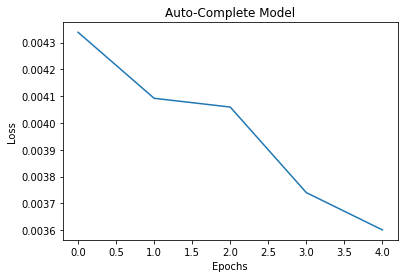

In [156]:
plt.plot(loss_lst)
plt.title('Auto-Complete Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')